# Table of Contents

* [Overview](#0)
* [Importing Libraries](#1)
* [Load Dataset](#2)
* [Data Visualization](#3)
* [Text Preprocessing](#4)
* [Build Model with Pytorch](#5)
* [Prediction](#7)

In [1]:
# nltk is one of the most useful libraries when it comes to nlp
!pip install nltk==3.8

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 24.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8 which is incompatible.


<a id="0"></a>
# Overview

In this notebook, we are going to do semantic analysis on hotel reviews from Tripadvisor. We will 2 different approaches:
1. With machine learning models using sklearn
2. With deep neural network using tensorflow

There are also some text preprocessing before we train our model to make sure that our data is clean. At the end of this notebook, we will try to predict the sentiment of our own review

**So, let's dive into the code!**

<a id="1"></a>
# Importing Libraries

In [2]:
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Preprocessing and evaluation
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Models
import torch
from tqdm import tqdm
torch.cuda.is_available()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


True

<a id="1"></a>
# Load Dataset

In [3]:
df = pd.read_csv('../input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


As you can see from above details, there is **no null values** in this dataset

<a id="4"></a>
# Text Preprocessing

In [10]:
# Let's change the rating to be more general and easier to understand
def rating(score):
    if score > 3:
        return 2 # Good
    elif score == 3:
        return 1 # Neutral
    else:
        return 0 # Bad

In [11]:
df['Rating'] = df['Rating'].apply(rating)

In [12]:
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,2
1,ok nothing special charge diamond member hilto...,0
2,nice rooms not 4* experience hotel monaco seat...,1
3,"unique, great stay, wonderful time hotel monac...",2
4,"great stay great stay, went seahawk game aweso...",2


# Lemmatization

In [14]:
def cleaning(text):
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()
    
    #remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]
    
    #lemmatize the word
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

In [15]:
df['Review'] = df['Review'].apply(cleaning)

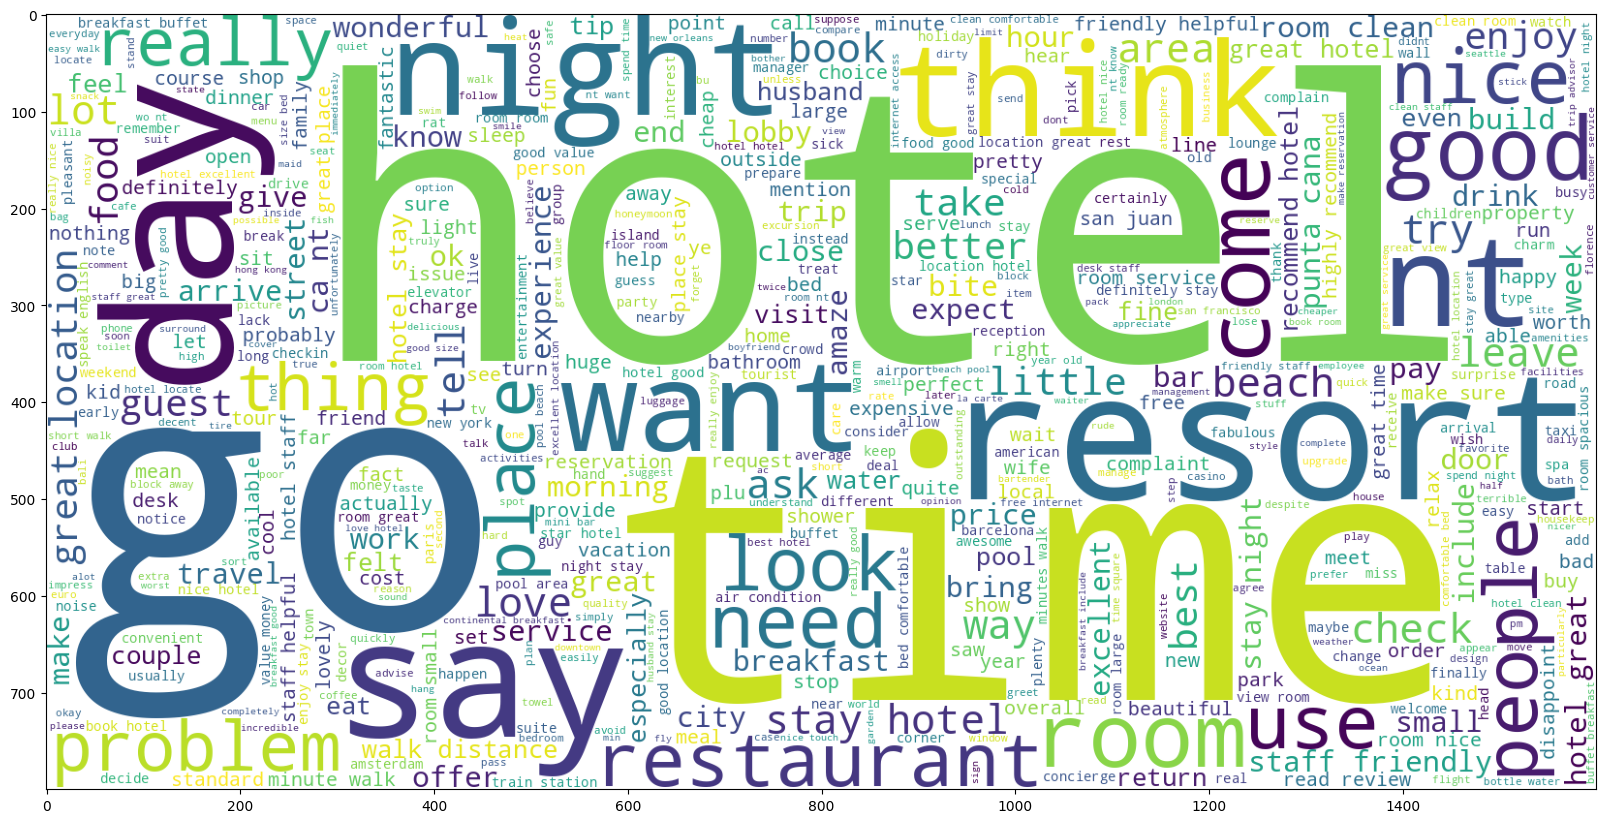

In [17]:
# After cleaning, let's see the most common used word
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, min_font_size=10, 
                height=800,width=1600,background_color="white").generate(' '.join(df['Review']))

plt.imshow(wc)

In [18]:
df.to_csv("/kaggle/working/processed_data.csv")

In [19]:
df = pd.read_csv("/kaggle/working/processed_data.csv")

In [20]:
df.head()

,Unnamed: 0,Review,Rating
0,0,nice hotel expensive park get good deal stay h...,2
1,1,ok nothing special charge diamond member hilto...,0
2,2,nice room 4 experience hotel monaco seattle go...,1
3,3,unique great stay wonderful time hotel monaco ...,2
4,4,great stay great stay go seahawk game awesome ...,2


In [77]:
# Set a random seed for reproducibility
random_seed = 42

# First, split into training and temporary set (combining validation and test)
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    df['Review'], df['Rating'], test_size=0.2, random_state=random_seed
)

# Now split the temporary set into validation and test sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_temp, y_train_temp, test_size=0.25, random_state=random_seed  # 0.25 x 0.8 = 0.2
)

<a id="5"></a>
# Building Model with Pytorch

In [78]:
# build vocabulary, convert text => number
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')

tokenizer.fit_on_texts(X_train)
# print(tokenizer.word_index)
total_word = len(tokenizer.word_index)
print('Total distinct words: {}'.format(total_word))

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=80)

X_valid = tokenizer.texts_to_sequences(X_valid)
X_valid = pad_sequences(X_valid, maxlen=80)

X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=80)

Total distinct words: 53918


In [79]:
y_train = y_train.to_numpy()
y_valid = y_valid.to_numpy()
y_test = y_test.to_numpy()

In [80]:
y_train.shape

(12294,)

# BILSTM

In [81]:
class SentimentAnalysis(torch.nn.Module):

    def __init__(self, total_word, embed_size, hidden_size, num_class, padding_index=0):
        super().__init__()
        self.total_word = total_word
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_class = num_class
        
        self.embed = torch.nn.Embedding(num_embeddings=total_word, 
                                        embedding_dim=embed_size, 
                                        padding_idx=padding_index)
        self.lstm = torch.nn.LSTM(input_size=self.embed_size, 
                                  hidden_size=self.hidden_size, 
                                  num_layers=1,
                                  bidirectional=True,
                                  batch_first=True)
        self.classifier = torch.nn.Sequential(
            # TODO: add more Linear layer, Activation layer
            torch.nn.Linear(in_features=2*self.hidden_size, out_features=num_class)
        )
        
    def forward(self, X):
        out = self.embed(X)
        out, _ = self.lstm(out)
        out = self.classifier(out[:, -1, :])
        return out

# Optimizer

In [82]:
class lion_optimizer(torch.optim.Optimizer): 

    def __init__(self, params, learning_rate = 1e-3, beta1 = 0.9, beta2 = 0.99, lambdaa = 0.01):
        super(lion_optimizer, self).__init__(params, defaults={'lr': learning_rate})
        self.state = dict()
        self.beta1 = beta1
        self.beta2 = beta2
        self.lambdaa = lambdaa
        for group in self.param_groups:
            for p in group['params']:
                self.state[p] = dict(momentum = torch.zeros_like(p.data))

    def step(self): 
        for group in self.param_groups:
            for p in group['params']:
                if p not in self.state: 
                    self.state[p] = dict(momentum = torch.zeros_like(p.data))
                m = self.beta1 * self.state[p]['momentum'] + (1 - self.beta1) * p.grad.data
                p.data -= group['lr'] * (torch.sign(m) + self.lambdaa * p.data)
                m = self.beta2 * self.state[p]['momentum'] + (1 - self.beta2) * p.grad.data
                self.state[p]['momentum'] = m

# Training Loop

In [108]:
NUM_VOCAB = total_word
EMBED_SIZE = 128
HIDDEN_SIZE = 164
NUM_CLASS = 3
BATCH_SIZE = 32
EPOCHS = 20
LAMBDA = 0.01

lion_learningRate_ablation_train_accuracy = {}
lion_learningRate_ablation_valid_accuracy = {}

num_train = X_train.shape[0]
num_valid = X_valid.shape[0]
inds = np.arange(num_train)
inds_valid = np.arange(num_valid)

# Define your optimizer
optimizer = lion_optimizer(model.parameters(), learning_rate=LEARNING_RATE, lambdaa=LAMBDA)
loss_func = torch.nn.CrossEntropyLoss()

# Helper function to calculate accuracy
def calculate_accuracy(y_pred, y_true):
    _, predicted = torch.max(y_pred.data, 1)
    total = y_true.size(0)
    correct = (predicted == y_true).sum().item()
    return correct / total

learning_rates = [x * 0.0001 for x in range(1, 11)] + [x * 0.001 for x in range(1, 11)] + [x * 0.01 for x in range(1, 11)]

for lr in learning_rates:
    lion_learningRate_ablation_train_accuracy[lr] = []
    lion_learningRate_ablation_valid_accuracy[lr] = []
    model = SentimentAnalysis(total_word=NUM_VOCAB, embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, num_class=NUM_CLASS)
    model = model.to("cuda")
    optimizer = lion_optimizer(model.parameters(), learning_rate=lr, lambdaa=0.01)
    BATCH_SIZE = 128
    EPOCH = 20
    print("")
    print(lr)
    
    for e in range(EPOCH):
        model.train()
        total = 0
        correct = 0
        pbar = tqdm(range(0, X_train.shape[0], BATCH_SIZE), desc="Epoch {}".format(e+1))
        for i in pbar:
            x = torch.Tensor(X_train[inds[i:i+BATCH_SIZE]])
            x = x.type(dtype=torch.IntTensor).to("cuda")
            y_hat = model(x)
            y = torch.Tensor(y_train[inds[i:i+BATCH_SIZE]])
            y = y.type(dtype=torch.LongTensor).to("cuda")
            loss = loss_func(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(y_hat.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

            # Update progress bar
            train_accuracy = 100 * correct / total
            pbar.set_description("Epoch: {} - Loss: {:.4f} - Acc: {:.2f}%".format(e + 1, loss.item(), train_accuracy))
        
        lion_learningRate_ablation_train_accuracy[lr].append(100 * correct / total)

        # Validation Accuracy Calculation
        model.eval()
        with torch.no_grad():
            pbar = tqdm(range(0, X_valid.shape[0], BATCH_SIZE), desc="Epoch {}".format(e+1))
            correct  = 0
            total = 0
            for i in pbar:
                x = torch.Tensor(X_valid[inds_valid[i:i+BATCH_SIZE]])
                x = x.type(dtype=torch.IntTensor).to("cuda")
                y_hat = model(x)
                y = torch.Tensor(y_valid[inds_valid[i:i+BATCH_SIZE]])
                y = y.type(dtype=torch.LongTensor).to("cuda")

                # Calculate accuracy
                _, predicted = torch.max(y_hat.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()

            # Update progress bar
            valid_accuracy = 100 * correct / total
            
            lion_learningRate_ablation_valid_accuracy[lr].append(valid_accuracy)
            
            print("Validation Accuracy : ",valid_accuracy)
                
           


0.0001


Epoch 1: 100%|██████████| 33/33 [00:00<00:00, 43.47it/s]


Validation Accuracy :  73.74328940946803


Epoch 2: 100%|██████████| 33/33 [00:00<00:00, 43.31it/s]


Validation Accuracy :  73.91410444119083


Epoch 3: 100%|██████████| 33/33 [00:00<00:00, 43.34it/s]


Validation Accuracy :  73.81649585163494


Epoch 4: 100%|██████████| 33/33 [00:00<00:00, 43.52it/s]


Validation Accuracy :  74.49975597852611


Epoch 5: 100%|██████████| 33/33 [00:00<00:00, 43.55it/s]


Validation Accuracy :  76.81795998047828


Epoch 6: 100%|██████████| 33/33 [00:00<00:00, 43.43it/s]


Validation Accuracy :  78.62371888726207


Epoch 7: 100%|██████████| 33/33 [00:00<00:00, 43.49it/s]


Validation Accuracy :  79.0141532454856


Epoch 8: 100%|██████████| 33/33 [00:00<00:00, 43.49it/s]


Validation Accuracy :  80.23426061493412


Epoch 9: 100%|██████████| 33/33 [00:00<00:00, 43.33it/s]


Validation Accuracy :  80.74670571010249


Epoch 10: 100%|██████████| 33/33 [00:00<00:00, 43.41it/s]


Validation Accuracy :  80.42947779404588


Epoch 11: 100%|██████████| 33/33 [00:00<00:00, 43.44it/s]


Validation Accuracy :  79.89263055148854


Epoch 12: 100%|██████████| 33/33 [00:00<00:00, 43.44it/s]


Validation Accuracy :  79.96583699365544


Epoch 13: 100%|██████████| 33/33 [00:00<00:00, 43.45it/s]


Validation Accuracy :  79.6730112249878


Epoch 14: 100%|██████████| 33/33 [00:00<00:00, 43.50it/s]


Validation Accuracy :  79.20937042459737


Epoch 15: 100%|██████████| 33/33 [00:00<00:00, 43.14it/s]


Validation Accuracy :  80.62469497315763


Epoch 16: 100%|██████████| 33/33 [00:00<00:00, 43.46it/s]


Validation Accuracy :  79.1849682772084


Epoch 17: 100%|██████████| 33/33 [00:00<00:00, 43.44it/s]


Validation Accuracy :  78.16007808687165


Epoch 18: 100%|██████████| 33/33 [00:00<00:00, 43.41it/s]


Validation Accuracy :  78.5261102977062


Epoch 19: 100%|██████████| 33/33 [00:00<00:00, 43.37it/s]


Validation Accuracy :  78.40409956076135


Epoch 20: 100%|██████████| 33/33 [00:00<00:00, 43.40it/s]


Validation Accuracy :  78.79453391898487

0.0002


Epoch 1: 100%|██████████| 33/33 [00:00<00:00, 43.29it/s]


Validation Accuracy :  73.86530014641288


Epoch 2: 100%|██████████| 33/33 [00:00<00:00, 43.11it/s]


Validation Accuracy :  73.71888726207906


Epoch 3: 100%|██████████| 33/33 [00:00<00:00, 43.47it/s]


Validation Accuracy :  76.93997071742314


Epoch 4: 100%|██████████| 33/33 [00:00<00:00, 43.49it/s]


Validation Accuracy :  78.79453391898487


Epoch 5: 100%|██████████| 33/33 [00:00<00:00, 43.47it/s]


Validation Accuracy :  81.13714006832602


Epoch 6: 100%|██████████| 33/33 [00:00<00:00, 43.41it/s]


Validation Accuracy :  80.79551000488043


Epoch 7: 100%|██████████| 33/33 [00:00<00:00, 43.52it/s]


Validation Accuracy :  78.86774036115177


Epoch 8: 100%|██████████| 33/33 [00:00<00:00, 43.52it/s]


Validation Accuracy :  78.81893606637384


Epoch 9: 100%|██████████| 33/33 [00:00<00:00, 43.52it/s]


Validation Accuracy :  78.18448023426062


Epoch 10: 100%|██████████| 33/33 [00:00<00:00, 43.48it/s]


Validation Accuracy :  77.30600292825768


Epoch 11: 100%|██████████| 33/33 [00:00<00:00, 43.33it/s]


Validation Accuracy :  76.57393850658858


Epoch 12: 100%|██████████| 33/33 [00:00<00:00, 43.59it/s]


Validation Accuracy :  77.57442654953635


Epoch 13: 100%|██████████| 33/33 [00:00<00:00, 43.44it/s]


Validation Accuracy :  77.11078574914592


Epoch 14: 100%|██████████| 33/33 [00:00<00:00, 43.47it/s]


Validation Accuracy :  77.50122010736945


Epoch 15: 100%|██████████| 33/33 [00:00<00:00, 43.50it/s]


Validation Accuracy :  79.20937042459737


Epoch 16: 100%|██████████| 33/33 [00:00<00:00, 43.11it/s]


Validation Accuracy :  78.98975109809663


Epoch 17: 100%|██████████| 33/33 [00:00<00:00, 43.46it/s]


Validation Accuracy :  79.57540263543191


Epoch 18: 100%|██████████| 33/33 [00:00<00:00, 43.15it/s]


Validation Accuracy :  77.33040507564665


Epoch 19: 100%|██████████| 33/33 [00:00<00:00, 43.55it/s]


Validation Accuracy :  77.81844802342606


Epoch 20: 100%|██████████| 33/33 [00:00<00:00, 43.38it/s]


Validation Accuracy :  77.35480722303562

0.00030000000000000003


Epoch 1: 100%|██████████| 33/33 [00:00<00:00, 43.03it/s]


Validation Accuracy :  73.767691556857


Epoch 2: 100%|██████████| 33/33 [00:00<00:00, 43.42it/s]


Validation Accuracy :  75.89067837969742


Epoch 3: 100%|██████████| 33/33 [00:00<00:00, 43.45it/s]


Validation Accuracy :  79.55100048804294


Epoch 4: 100%|██████████| 33/33 [00:00<00:00, 43.42it/s]


Validation Accuracy :  79.77061981454368


Epoch 5: 100%|██████████| 33/33 [00:00<00:00, 43.46it/s]


Validation Accuracy :  79.1849682772084


Epoch 6: 100%|██████████| 33/33 [00:00<00:00, 43.44it/s]


Validation Accuracy :  78.69692532942899


Epoch 7: 100%|██████████| 33/33 [00:00<00:00, 43.46it/s]


Validation Accuracy :  79.20937042459737


Epoch 8: 100%|██████████| 33/33 [00:00<00:00, 43.51it/s]


Validation Accuracy :  76.232308443143


Epoch: 9 - Loss: 0.0786 - Acc: 85.87%:  26%|██▌       | 25/97 [00:00<00:02, 27.68it/s]


KeyboardInterrupt: 

# Saving Results

In [ ]:
import json

# Save the dictionary to a file
with open('lion_learningRate_ablation_train_accuracy.json', 'w') as file:
    json.dump(lion_learningRate_ablation_train_accuracy, file)


# Save the dictionary to a file
with open('lion_learningRate_ablation_valid_accuracy.json', 'w') as file:
    json.dump(lion_learningRate_ablation_valid_accuracy, file)
